Notebook showing usage of the data detective.

In [1]:
# To import detective from relative folder
import detective.core as detective
import pandas as pd
pd.options.mode.chained_assignment = None  # Suppress chained_assignment warning, default='warn'
from sqlalchemy import text
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!pip show HASS-data-detective|grep Version

Version: 1.0


To load the local db we supply the path to the sqlite `.db` file 

In [3]:
%%time
db = detective.HassDatabase('sqlite:///home-assistant_v2.db') # To init without fetching entities fetch_entities=False

Successfully connected to database sqlite:///home-assistant_v2.db
There are 5 entities with data
CPU times: user 80 ms, sys: 0 ns, total: 80 ms
Wall time: 156 ms


In [4]:
db.domains

['group', 'automation', 'history_graph', 'sensor', 'camera']

In [5]:
db.entities['sensor']

['sensor.merton',
 'sensor.particles_01um',
 'sensor.particles_025um',
 'sensor.particles_10um',
 'sensor.serial_sensor']

## Simple query

Lets query a single sensor and demonstrate the data processing steps implemented by the library

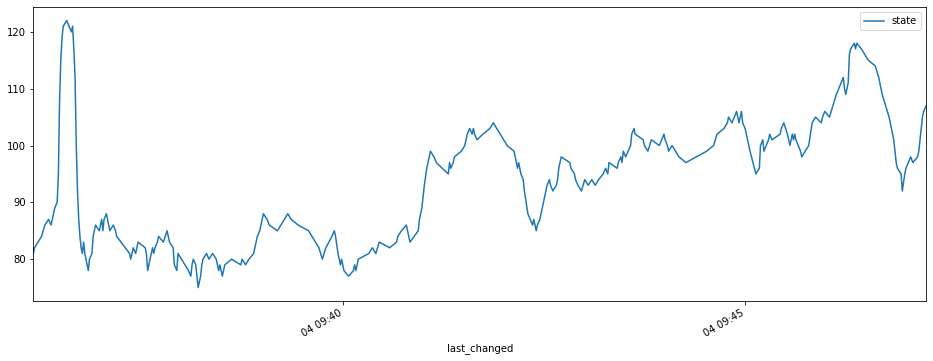

In [6]:
query = text(
    """
    SELECT state, last_changed
    FROM states
    WHERE entity_id in ('sensor.particles_01um') 
    AND NOT state='unknown'
    """
    )
response = db.perform_query(query)
df = pd.DataFrame(response.fetchall()) # Convert to dataframe
df.columns = ['state', 'last_changed'] # Set the columns
df = df.set_index('last_changed') # Set the index on datetime
df.index = pd.to_datetime(df.index) # Convert string to datetime
df = df.mask(df.eq('None')).dropna().astype(float) #  Convert state strings to floats for plotting
df.plot(figsize=(16, 6));

## Helper to query by list
Use `fetch_data_by_list` to query a list of numerical entities, must be from same domain and a minimum of 2 entities must be in the list. Returns a pandas dataframe.

In [7]:
air_sensors = ['sensor.particles_10um',
               'sensor.particles_025um',
               'sensor.particles_01um',]

df = db.fetch_data_by_list(air_sensors)

df.head()

entity,sensor.particles_01um,sensor.particles_025um,sensor.particles_10um
last_changed,,,
2018-12-04 09:36:08.602089+00:00,81.0,106.0,115.0
2018-12-04 09:36:09.548357+00:00,82.0,106.0,115.0
2018-12-04 09:36:09.548566+00:00,82.0,107.0,115.0
2018-12-04 09:36:09.548759+00:00,82.0,107.0,119.0
2018-12-04 09:36:12.128323+00:00,83.0,107.0,119.0


In [8]:
df['sensor.particles_01um'].describe()

count    1069.000000
mean       93.130964
std        10.864317
min        75.000000
25%        83.000000
50%        94.000000
75%       101.000000
max       122.000000
Name: sensor.particles_01um, dtype: float64

## Query all data
Data-detective takes care of parsing data from the database, intelligently sorting out numerical and categorical data and formatting them correctly. Use `fetch_all_data` to import all your db data into a pandas dataframe in memory -> this approach means it can take a while to load the data into memory, but subsequent processing and handling are much faster/easier.

In [9]:
%%time
db.fetch_all_data()

Querying the database, this could take a while
master_df created successfully.
CPU times: user 10 ms, sys: 20 ms, total: 30 ms
Wall time: 92.1 ms


The `NumericalSensors` class is for parsing the numerical data. Lets create a dataframe for the numerical sensor data

In [10]:
sensors_num_df = detective.NumericalSensors(db.master_df)

We can access the list of sensor entities using the list_sensors attribute

In [11]:
sensors_num_df.entities

['sensor.particles_10um', 'sensor.particles_025um', 'sensor.particles_01um']

Now lets look at the dataframe

In [12]:
sensors_num_df.data.head()

entity,sensor.particles_01um,sensor.particles_025um,sensor.particles_10um
last_changed,,,
2018-12-04 09:36:08.602089,81.0,106.0,115.0
2018-12-04 09:36:09.548357,82.0,106.0,115.0
2018-12-04 09:36:09.548566,82.0,107.0,115.0
2018-12-04 09:36:09.548759,82.0,107.0,119.0
2018-12-04 09:36:12.128323,83.0,107.0,119.0


Lets now check for correlations in the data:

In [13]:
corrs = sensors_num_df.correlations()

/opt/conda/lib/python3.7/site-packages/detective/core.py:261: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  corrs.append(corr_df.ix[i, j])
/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]


In [14]:
corrs[(corrs['value'] > 0.8) | (corrs['value'] < -0.8)]

,value
sensor.particles_025um-sensor.particles_10um,0.958906
sensor.particles_01um-sensor.particles_025um,0.954635
sensor.particles_01um-sensor.particles_10um,0.861816


Unsurprisingly the mean temperature is strongly correlated with all of the temperature sensors. 

Interestingly my iphone battery level is somewhat inversely correlated with the travel time from home to waterloo, which gets longer late at night when my battery level is more likely to be low. 

#### Plot sensor data
Convenience to plot a sensor data.
Pass a single entity to plot:

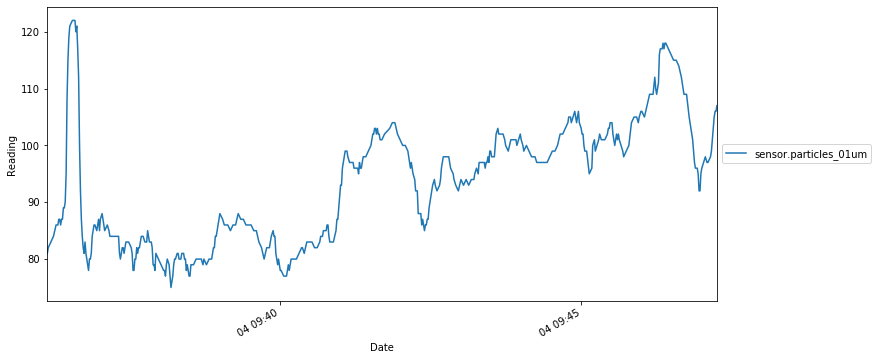

In [15]:
sensors_num_df.plot('sensor.particles_01um')

We can pass a list of entities to plot:

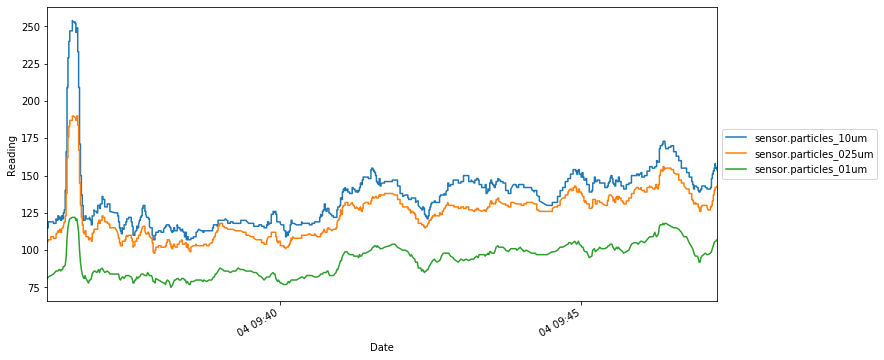

In [16]:
sensors_num_df.plot(air_sensors)

That concludes our introduction to detective